# Analysis of trial-based photometry data

This notebook illustrates a pipeline for pre-processing and analysing fiber photometry data from behavioural tasks with a discrete trial structure.  The repository contains python modules for pre-processing and analysing the data, as well as an example dataset consisting of 5 sessions each from 9 subjects perfoming a probabilistic reversal learning task, with dLight photometry recordings in the dorsolateral striatum.  The experiment was run using [pyControl](https://pycontrol.readthedocs.io) to implement the behavioural task and [pyPhotometry](https://pyphotometry.readthedocs.io) to aquire the photometry signals.  The repository structure is:

```
photometry_analysis_repository
├── code                           # Folder containing modules used in the analysis pipepine.
    ├── photometry_analysis.ipynb  # This notebook.
    ├── preprocessing              # Code for preprocessing data.
    ├── analysis                   # Code for analysing data.
├── data
    ├── raw                    
        ├── pyControl              # Behavioural data generated by pyControl
        ├── photometry             # Photometry data generated by pyPhotometry         
```

The code that implements the analysis pipeline is designed to be applicable across different experiments and behavioural tasks, though it expects the tasks to have discrete trials, in which on every trial there are a set of events that will be used to time-align the photometry signals, and variables which vary from trial-to-trial which will be used for analysis. In the example reversal learning dataset included in the repository, each trial starts with the subject poking a central nose-poke port to initiate the trial, then choosing between a left and right port for probabilistic reward.  The events that will be used to time align the photometry data are the trial initiation and subject's choice, and various variables will be used for analysis including the choices made by the subject and the trial outcome.  All task-specific code used to configure the analysis pipeline for the example dataset is in this notebook, while all code in the `code` folder should be task-general.

The pipeline makes heavy use of [Pandas](https://pandas.pydata.org/) dataframes, as they are a fantastic tool for representing complex datasets in a way that is easy to examine, understand, manuipulate and plot. The code mostly takes a functional rather than object oriented approach, eschewing custom classes with the exception of a `Session` class in `code.session` which handles loading the various individual files that comprise a session's processed data, and storing them on the Session object for easy access.  We hope these design choices make the code accessible and straightforward to modify and extend.

The pipeline consists of 3 steps:

1. **Pre-processing:** This step takes the raw data files generated by the experimental hardware and transforms them into a new representation of the data on disk saved in a seperate `data/processed` folder.  This transformation changes the data in several ways:
    - Convert the data into a representation on disk that is straightforward to open in any programming language as it uses only generic file formats containing simple data structures, organised onto one folder for each session.  We use `.npy` ([Numpy](https://numpy.org/doc/stable/reference/generated/numpy.lib.format.html)) files for arrays of numerical data, `.htsv` ([tab-seperated value](https://en.wikipedia.org/wiki/Tab-separated_values) with header row) files for tables of hetrogenous data, and `.json` ([JSON](https://www.json.org/json-en.html)) files for dictionaries of key-value pairs.
    - Align the time reference frames between data acquired by different systems such that all time measurments in the processed data are in seconds relative to the start of the behavioural session.
    - Preprocess the phototometry data to correct for photobleaching and movement artifacts, using the methods detailed in a seperate [photometry preprocessing](https://github.com/ThomasAkam/photometry_preprocessing) notebook, here implemented as a function in the `code.photometry_data_import` module.
    
2. **Make analysis data:** This step loads the pre-processed data and creates the data structures that will be used by the analysis functions. These data are saved out in a `data/analysis` folder to avoid having to recacluate them each time analyes are run.  The rationale for keeping them seperate from the processed data is: i) To keep the size of the processed data to a minimum, to facilitate sharing or publication of the data.  ii) The analysis data structures  are likely to change over the course of working on a project as the analyses evolve, whereas the processed data are fixed once preprocessing is done.  The analysis data consists of:
   - The trial-aligned photometry signal, i.e. the photometry signal on each trial aligned to one or more behavioural events on that trial.
   - Variables needed for analysis, such as the trial-by-trial values of predictors that will be used in regression analyses of the data.

4. **Run analyses:**  This step runs analysis functions on the data structures generated in the previous steps to make plots run statistical tests.

## Pre-processing

The first stage of the analysis pipeline is preprocessing the data to change it from the raw output of the acqusition systems into a format that is convinient to work with.  We first import the modules needed, and define the folder paths where the raw data is located and where outputs of the pipeline will be saved.

In [6]:
# Imports
import numpy as np
import pandas as pd
import pylab as plt
from pathlib import Path
from pprint import pprint
import preprocessing.preprocess_data as pp
import analysis.analysis as an

# Paths
raw_data_dir = Path('..', "data", "raw")              # Folder where the raw data is located.
processed_data_dir = Path('..', "data", "processed")  # Folder where the processed data will be saved.
analysis_data_dir = Path('..', "data", "analysis")    # Folder where analysis data will be saved.
plots_dir = Path('..', "plots")                       # Path where plots will be saved.

The only experiment-specific information we need to provide at this point are the behavioural events whose times we want to record on each trial, which will be used later for aligning activity.  The `trial_events` variable below specifies that we want to record the time of trial `"initiation"` and `"choice"`, and gives the pyControl state entries that can correspond to each of these trial events.  For more information see the docstring of `code.preprocess_data._add_trial_times`.

In [ ]:
trial_events = {
        "initiation": ("choice_state", "forced_choice_left", "forced_choice_right"),
        "choice": ("chose_left", "chose_right"),
}

pp.preprocess_data(raw_data_dir, processed_data_dir, plots_dir, trial_events)

After the `preprocess_data` function has run, the folder structure will be:

```
photometry_analysis_repository
├── code                           # Folder containing modules used in the analysis pipepine.
    ├── photometry_analysis.ipynb  # This notebook.
    ├── preprocessing              # Code for preprocessing data.
    ├── analysis                   # Code for analysing data.
├── data
    ├── raw                    
        ├── pyControl              # Behavioural data generated by pyControl
        ├── photometry             # Photometry data generated by pyPhotometry     
    ├── processed 
        ├── subject_dir            # Directory for each subject, name given by the subject ID.
            ├── session_dir        # Directory for each session, name given by start datetime. 
```
In each `session_dir` there will be the following files:

- `session_info.json` A dictionary with information about the session including the subject ID, start date-time, end date-time, etc.

- `events.htsv` Table containing behavioural task state entries and events, with one row per state entry/event, with columns *time*, *type* (state or event) and *name*.

- `trials.htsv` Table with one row per trial of the behavioural task containing information about what happened on the trial and the times of trial events.

- `variables.json` Dictionary with the values of task variables at the end of the session.

- `photometry_info.json` Information about the photometry recordings including acqusition mode, sampling rate, LED current and recording hemisphere.

- `dlight.signal.npy` The pre-processed photometry signal after photobleaching and movement correction.

- `dlight.times.npy` The times of the photometry signal samples in seconds since the start of the behavioural session.

We can load the preprocessed data for all sessions using:

In [ ]:
sessions = an.load_sessions(processed_data_dir)

This loads each sessions data as a Session object, lets look at one of these objects:

In [9]:
session = sessions[0]

pprint(session.info) # The contents of 'session_info.json'

Session_info(path=WindowsPath('../data/processed/01_C3T1_R/2023-11-13-114533'),
             analysis_data_dir=WindowsPath('../data/analysis/01_C3T1_R/2023-11-13-114533'),
             session_id='01_C3T1_R-2023-11-13-114533',
             experiment_name='Thomas\\LRRK2_photometry',
             task_name='Thomas\\reversal_learning',
             task_file_hash='2655257290',
             setup_id='Box 1',
             framework_version='2.0rc1',
             micropython_version='1.12',
             subject='01_C3T1_R',
             start_time=datetime.datetime(2023, 11, 13, 11, 45, 33, 943000),
             end_time=datetime.datetime(2023, 11, 13, 13, 15, 33, 906000),
             day=1,
             number=1,
             genotype='A')


(0.0, 20.0)

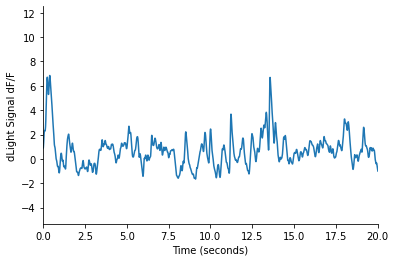

In [10]:
plt.plot(session.photometry.times, session.photometry.signal) # Plot the photometry signal.
plt.xlabel('Time (seconds)')
plt.ylabel('dLight Signal dF/F')
plt.xlim(0,20)

In [11]:
session.events_df # Contents of 'events.htsv' as a Dataframe with one row per event/state entry.

,time,type,name
0,0.000,state,initiation_state
1,0.002,event,poke_6
2,0.193,event,poke_6_out
3,0.387,event,poke_6
4,1.215,event,poke_6_out
...,...,...,...
5613,5126.992,event,poke_6_out
5614,5127.993,event,consumption_timer
5615,5127.993,state,inter_trial_interval
5616,5130.022,state,initiation_state


In [12]:
session.trials_df # Contents of 'trials.htsv' as a Dataframe with one row per trial,
                  # containing information about the trial and the times of trial events.

n_trials n_rewards n_blocks forced_choice good_poke  choice correct  \
                                                                          
0          1         0        0         False    poke_4  poke_6   False   
1          2         0        0         False    poke_4  poke_6   False   
2          3         1        0         False    poke_4  poke_4    True   
3          4         1        0          True    poke_4  poke_6   False   
4          5         1        0         False    poke_4  poke_4    True   
..       ...       ...      ...           ...       ...     ...     ...   
361      362       161        4         False    poke_4  poke_4    True   
362      363       161        4         False    poke_4  poke_4    True   
363      364       162        4          True    poke_4  poke_6   False   
364      365       162        4         False    poke_4  poke_6   False   
365      366       162        4          True    poke_4  poke_6   False   

    outcome   mov_ave threshold_crossed      times            
                                        initiation    choice  
0     False  0.441248             False      1.818     2.235  
1     False  0.389400             False      7.437     8.119  
2      True  0.461148             False     12.313    12.892  
3     False  0.461148             False     21.718    24.122  
4     False  0.524465             False     28.718    29.122  
..      ...       ...               ...        ...       ...  
361   False  0.532645             False   5092.642  5093.189  
362   False  0.587561             False   5097.695  5098.229  
363    True  0.587561             False   5103.012  5105.382  
364   False  0.518521             False   5120.997  5121.535  
365   False  0.518521             False   5125.403  5125.922  

[366 rows x 12 columns]

The `trials_df` dataframe uses a MultiIndex for the column names.  This is an index which has multiple levels (here two) allowing conceptually related data to be grouped together.  Here this is used for the times of two different trial events, with the top-level index for these columns being `time` and the second level being `intiation` and `choice` respectively.  The code below shows some ways of accessing data in a dataframe with MultiIndex columns.

In [8]:
session.trials_df.times.initiation # Get the trial initation times column.

0         1.818
1         7.437
2        12.313
3        21.718
4        28.718
         ...   
361    5092.642
362    5097.695
363    5103.012
364    5120.997
365    5125.403
Name: initiation, Length: 366, dtype: float64

In [13]:
session.trials_df.times # Get both times columns.

,initiation,choice
0,1.818,2.235
1,7.437,8.119
2,12.313,12.892
3,21.718,24.122
4,28.718,29.122
...,...,...
361,5092.642,5093.189
362,5097.695,5098.229
363,5103.012,5105.382
364,5120.997,5121.535


In [10]:
session.trials_df.outcome # We can just specify the top-level index when the lower levels are empty.

0      False
1      False
2       True
3      False
4      False
       ...  
361    False
362    False
363     True
364    False
365    False
Name: outcome, Length: 366, dtype: bool

In [11]:
session.trials_df.loc[0, ('times','choice')] # Access one cell by specifying row and multi-index column.

2.235

In [14]:
session.trials_df.loc[0,'times'] # Access both times column values from one row.

initiation    1.818
choice        2.235
Name: 0, dtype: object

## Make analysis data

We now make some additional data structures that will be useful for analysis.  We do this by supplementing the trials dataframe with the trial aligned photometry signals, and additional variables that we will use for analysis.  There are two ways we can generate trial aligned signals:
1. The simplest method is to take windows around events of interest.  We will do this for the trial initiation (when the subjects start the motor action associated with their choice) and choice (when subjects poke into a choice port and recieve the trial outcome).
2. Another approach is to align signals across the whole trial by time-warping the signal to align multiple trial events to their median timing across trials.  We will also use this method, with the time-warping implemented by the `align_signals` function in `code.align_activity`.

In [ ]:
median_trial_times = an.get_median_trial_times(  # Compute the median trial times that will be used for time warping.
    sessions, trial_events=["initiation", "choice"], save_dir=analysis_data_dir)

an.save_aligned_signals( # Generate the trial aligned activity and save it out to the analysis data folder.
    sessions, analysis_data_dir, trial_events=["initiation", "choice"],target_event_times=median_trial_times)

Running the above code has generated a new analysis data folder, resulting in the following folder structure:
```
photometry_analysis_repository
├── code                           # Folder containing modules used in the analysis pipepine.
    ├── photometry_analysis.ipynb  # This notebook.
    ├── preprocessing              # Code for preprocessing data.
    ├── analysis                   # Code for analysing data.
├── data
    ├── raw                    
        ├── pyControl              # Behavioural data generated by pyControl
        ├── photometry             # Photometry data generated by pyPhotometry     
    ├── processed 
        ├── subject_dir            # Directory for each subject, name given by the subject ID.
            ├── session_dir        # Directory for each session, name given by start datetime. 
    ├── analysis
        ├── subject_dir        # Directory for each subject, name given by the subject ID.
            ├── session_dir    # Directory for each session, name given by start date-time. 
```
Each session's analysis data directory currently has a single file in it called `trials.aligned_signal.parquet`.  Here we are using the [International Brain Lab naming convention](https://www.biorxiv.org/content/10.1101/827873v3) for files which uses file names structured as `object.attribute.extension`.  All files corresponding to the same object have the same first dimension, so here the object is `trials` and the first dimension has length *n_trials*.  The [parquet](https://parquet.apache.org/) file format is an open file format for saving out data tables to disk.  Unlike tab-seperated-value (tsv) files it is not human readable, but it is faster to save and load and takes up less space on disk.  [Tad](https://www.tadviewer.com/) is a nice free cross-platform application for viewing tabular data files (including tsv and parquet).

In addition to saving out the trial aligned firing rates, we will save out an additional dataframe for each session containing the trial-by-trial value of some additional variables that we will use for analysing the signals.

In [14]:
def make_analysis_variables_df(session):
    # Make variable indicating whether each trials choice was contra- or ipsi-lateral to the fiber.
    contra_action = "poke_4" if session.photometry.hemisphere == "R" else "poke_6" 
    contra_choice = session.trials_df.choice == contra_action
    # Make variables coding for the previous trials outcome on trials where the previous choice was the same/different from the current choice.
    same_choice = session.trials_df.choice == session.trials_df.choice.shift(1) # True if choice is same as previous trial.
    prev_outcome = 2*(session.trials_df.outcome.shift(1, fill_value=0.5)-0.5)   # Previous trial outcome coded 1/-1 for reward/omission.
    prev_outcome_same = (prev_outcome*same_choice).astype(int)  # Previous trial outcome coded 1/-1 on trials where choice is same as previous trial
    prev_outcome_diff = (prev_outcome*~same_choice).astype(int) # Previous trial outcome coded 1/-1 on trials where choice is different from previous trial
    return pd.DataFrame({"contra_choice" : contra_choice,
                         "prev_outcome_same" : prev_outcome_same, 
                         "prev_outcome_diff" : prev_outcome_diff})

analysis_vars_df = make_analysis_variables_df(session)

analysis_vars_df

,contra_choice,prev_outcome_same,prev_outcome_diff
0,False,0,0
1,False,-1,0
2,True,0,-1
3,False,0,1
4,True,0,-1
...,...,...,...
361,True,1,0
362,True,-1,0
363,False,0,-1
364,False,1,0


In the `analysis_vars_df`, each row corresponds to one trial. The `contra_choice` column indicates whether the trials choice was contra- or ipi-lateral to the photometry fiber, as we expect to see signals associated with lateralised actions in DLS dopamine. The `prev_outcome_same` column codes for the previous trial outcome on trials where the choice is the same as that on the previous trial, and the `prev_outcome_diff` column codes for the previous outcome on trials where the choice is different from the previous trial.  We will use these variables to look for evidence of value updates from one trial to the next driven by the previous trials outcome.

We will now save out the analysis variables for all sessions to the analysis data folder.

In [15]:
for session in sessions:
    analysis_vars_df = make_analysis_variables_df(session)
    analysis_vars_df.to_parquet(Path(session.info.analysis_data_dir, "trials.analysis_variables.parquet"))

The session class has a get_analysis_df method for loading the analysis data we have saved out and returning a single dataframe with one row per trial containing the trial variables and aligned activity:

In [16]:
session.get_analysis_df()

n_trials n_rewards n_blocks forced_choice good_poke  choice correct  \
                                                                          
                                                                          
0          1         1        0         False    poke_4  poke_4    True   
1          2         2        0          True    poke_4  poke_4    True   
2          3         3        0         False    poke_4  poke_4    True   
3          4         4        0         False    poke_4  poke_4    True   
4          5         4        0         False    poke_4  poke_4    True   
..       ...       ...      ...           ...       ...     ...     ...   
347      348       187        8          True    poke_4  poke_4    True   
348      349       187        8         False    poke_4  poke_6   False   
349      350       187        8         False    poke_4  poke_6   False   
350      351       187        8          True    poke_4  poke_4    True   
351      352       187        8         False    poke_4  poke_6   False   

    outcome   mov_ave threshold_crossed  ...    aligned_signal  \
                                         ...             trial   
                                         ... 2.320000000000003   
0      True  0.558752             False  ...          1.385733   
1      True  0.558752             False  ...          0.848610   
2      True  0.610600             False  ...          1.762264   
3      True  0.656355             False  ...          0.741013   
4     False  0.696735             False  ...          1.109916   
..      ...       ...               ...  ...               ...   
347    True  0.109441             False  ...         -0.139265   
348   False  0.096581             False  ...         -0.577326   
349   False  0.085232             False  ...         -0.453643   
350   False  0.085232             False  ...         -0.953822   
351   False  0.075217             False  ...         -1.270676   

                                                                             \
                                                                              
    2.340000000000003 2.360000000000003 2.380000000000003 2.400000000000003   
0            1.312735          1.212913          1.089086          0.989660   
1            0.862593          0.902799          0.945302          0.954583   
2            1.495842          1.286348          1.163054          1.073931   
3            0.687760          0.555919          0.397312          0.279794   
4            1.226332          1.287468          1.315746          1.358501   
..                ...               ...               ...               ...   
347          0.109586          0.363882          0.503434          0.510417   
348         -0.605596         -0.662250         -0.721871         -0.770326   
349         -0.362248         -0.368929         -0.391557         -0.360702   
350         -0.872580         -0.812966         -0.790743         -0.792128   
351         -1.144995         -1.024105         -0.904991         -0.800900   

                                                                             \
                                                                              
    2.420000000000003 2.440000000000003 2.460000000000003 2.480000000000003   
0            0.968246          1.005482          1.035327          1.041080   
1            0.934319          0.900933          0.861010          0.816062   
2            0.958488          0.812340          0.674315          0.573963   
3            0.270799          0.425666          0.726819          1.077997   
4            1.406852          1.421699          1.385008          1.308414   
..                ...               ...               ...               ...   
347          0.446290          0.340300          0.190374          0.016981   
348         -0.799051         -0.789937         -0.746457         -0.713186   
349         -0.323258         -0.348930         -0.4

## Run analyses

Now we have created all the data structures we will need we can run some analyses. As all the code up to this point has been generating data structures that are saved to disk (in the processed and analysis data folders), it only needs to be run the first time you use this notebook.  Subsequently you can 
just import the required modules and load the sessions with:

In [ ]:
from pathlib import Path
import analysis.analysis as an

sessions = an.load_sessions(Path("..", "data", "processed"))

We will now combine the data from all sessions into a single dataframe. The rows are the same as those in the dataframe generated by `session.get_analysis_df()` but with additional columns indicating the subject, session_id, genotype and day of the experiment.

In [18]:
sessions_df = an.make_multisession_dataframe(sessions) # Make a dataframe containing data from all sessions.

sessions_df

subject                   session_id day genotype n_trials n_rewards  \
                                                                              
                                                                              
0    01_C3T1_R  01_C3T1_R-2023-11-13-114533   1        A        1         0   
1    01_C3T1_R  01_C3T1_R-2023-11-13-114533   1        A        2         0   
2    01_C3T1_R  01_C3T1_R-2023-11-13-114533   1        A        3         1   
3    01_C3T1_R  01_C3T1_R-2023-11-13-114533   1        A        4         1   
4    01_C3T1_R  01_C3T1_R-2023-11-13-114533   1        A        5         1   
..         ...                          ...  ..      ...      ...       ...   
347  10_C2T3_R  10_C2T3_R-2023-11-17-124607   5        B      348       187   
348  10_C2T3_R  10_C2T3_R-2023-11-17-124607   5        B      349       187   
349  10_C2T3_R  10_C2T3_R-2023-11-17-124607   5        B      350       187   
350  10_C2T3_R  10_C2T3_R-2023-11-17-124607   5        B      351       187   
351  10_C2T3_R  10_C2T3_R-2023-11-17-124607   5        B      352       187   

    n_blocks forced_choice good_poke  choice  ...    aligned_signal  \
                                              ...             trial   
                                              ... 2.320000000000003   
0          0         False    poke_4  poke_6  ...          0.882489   
1          0         False    poke_4  poke_6  ...          0.161819   
2          0         False    poke_4  poke_4  ...         -0.312426   
3          0          True    poke_4  poke_6  ...         -0.059157   
4          0         False    poke_4  poke_4  ...          0.245115   
..       ...           ...       ...     ...  ...               ...   
347        8          True    poke_4  poke_4  ...         -0.139265   
348        8         False    poke_4  poke_6  ...         -0.577326   
349        8         False    poke_4  poke_6  ...         -0.453643   
350        8          True    poke_4  poke_4  ...         -0.953822   
351        8         False    poke_4  poke_6  ...         -1.270676   

                                                                             \
                                                                              
    2.340000000000003 2.360000000000003 2.380000000000003 2.400000000000003   
0            0.992075          1.104881          1.157205          1.167646   
1            0.739835          1.428564          1.992108          2.250861   
2           -0.217920         -0.062760          0.033260          0.026858   
3           -0.123348         -0.098173          0.019818          0.148605   
4            0.355126          0.382163          0.365260          0.339461   
..                ...               ...               ...               ...   
347          0.109586          0.363882          0.503434          0.510417   
348         -0.605596         -0.662250         -0.721871         -0.770326   
349         -0.362248         -0.368929         -0.391557         -0.360702   
350         -0.872580         -0.812966         -0.790743         -0.792128   
351         -1.144995         -1.024105         -0.904991         -0.800900   

                                                                             \
                                                                              
    2.420000000000003 2.440000000000003 2.460000000000003 2.480000000000003   
0            1.176664          1.161198          1.081750          0.934108   
1            2.161087          1.805314          1.344740          0.936011   
2           -0.051897         -0.158930         -0.247004         -0.302818   
3            0.207427          0.189991          0.155711          0.184849   
4            0.333262          0.382376          0.514108          0.742564   
..                ...               ...               ...               ...   
347          0.446290          0.340300          0.190374          0.016981   
348     

There are two different types of analysis implemented in the analysis module, the first is to plot the photometry response aligned to trial events, with trials split by one or more variables. In these plots the line indicates the cross-subject mean and the shaded area the cross subject standard error. This is done using the an.plot_response function. Here is some example usage:

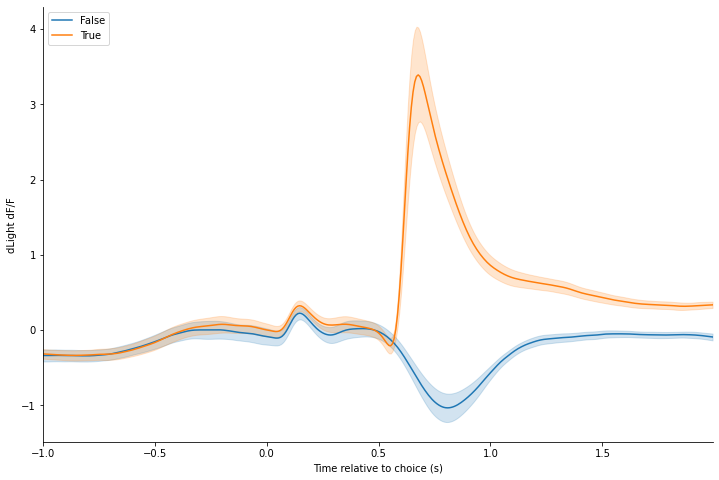

In [19]:
# Plot the response aligned to the subjects choice response with trials split by outcome.
an.plot_response(sessions_df, alignment="choice", hue="outcome")

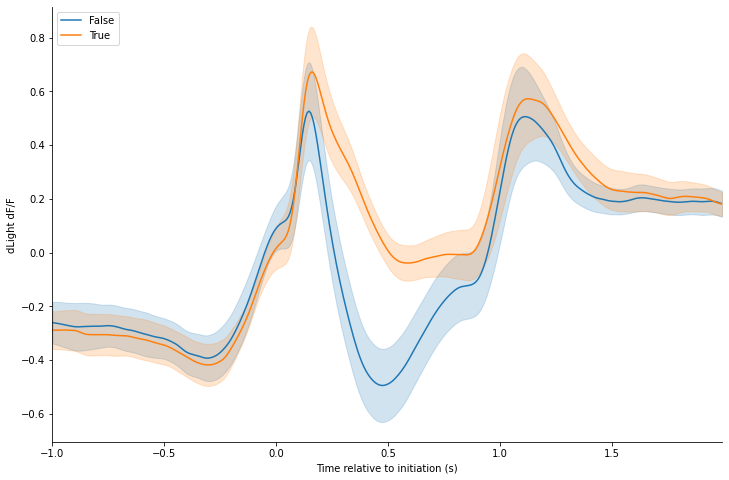

In [20]:
# Plot the response aligned to trial initiation, with trials split by contra- vs ipsilateral choice.
an.plot_response(sessions_df, alignment="initiation", hue="contra_choice")

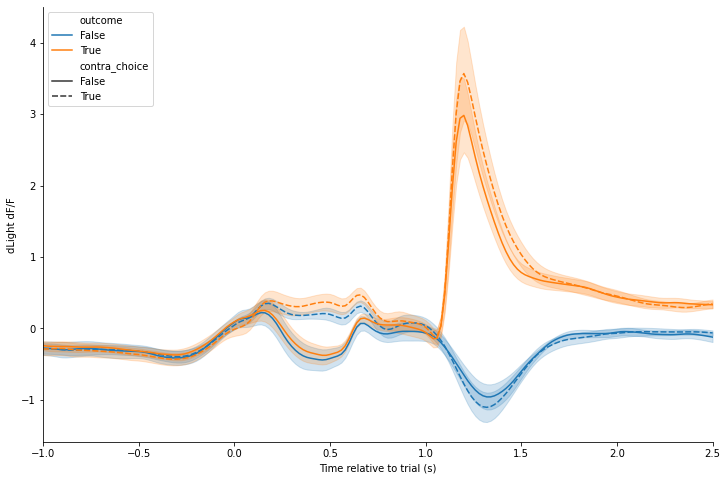

In [21]:
# Plot the response aligned to all trail event (using the time-warped signal), split by both outcome and ipsi/contra choice,
# with outcome indicated by line hue and contra choice indicated by line style.
an.plot_response(sessions_df, alignment="trial", hue="outcome", style="contra_choice")

The second type of analysis is a linear regression predicting the signal as a function of a set of different variables.  A seperate regression analysis is run for each timepoint in the aligned signal, giving a predictor loading (beta) for each predictor at each timepoint, which can be plotted to show when and with what sign each predictor explains variance in the aligned activity.  This is implemented by the `an.linear_regression` function.  The set of predictors to use is specified as a string corresponding to the right hand side of a [Statsmodels Formula API](https://www.statsmodels.org/stable/example_formulas.html) formula.  Note that all the predictor names we include in this string need to be the names of columns in the `sessions_df` dataframe.

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.05it/s]


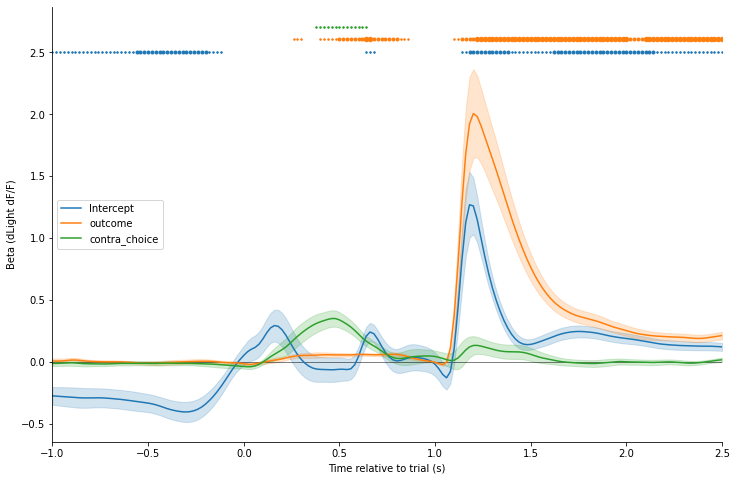

In [22]:
# Fit a regression model to the trial aligned data using trial outcome and contra/ipsi choice as predictors.
an.regression_analysis(sessions_df, formula="outcome + contra_choice", alignment="trial")

We can see in the above plot that there is significant loading on the outcome regressor before outcome information becomes available, because the dopamine signal is responding to the subjects expectation about the outcome.  Let's see what happens if we include an additional regressor for whether the subject chooses the correct (i.e. high reward probability option), which should be highly correlated with the subjects expectation about the trial outcome:

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.14s/it]


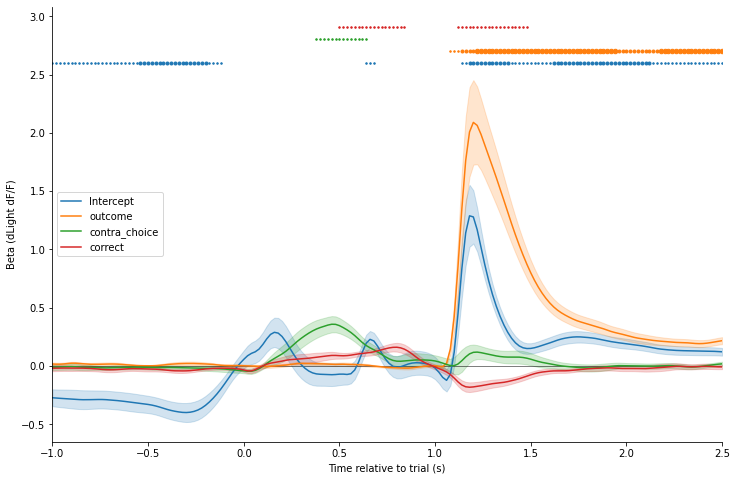

In [23]:
# Fit regression model using trial outcome, contra/ipsi choice, and correct/incorrect choice as regressors.
an.regression_analysis(sessions_df, formula="outcome + contra_choice + correct", alignment="trial")

We can see that including this *correct* choice predictor has removed loading on the *outcome* predictor prior to outcome information becoming available.  We can also see that the *correct* predictor has significant positive loading around the time of the choice, which then reverses sign when outcome information becomes available, consistent with reward prediction error signalling.  Finally, lets see if we can resolve an effect of the previous trial's outcome updating the value of the current trial choice, by including a predictor which codes for the previous outcome on trials where the choice is the same as on the previous trial:

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:12<00:00,  1.38s/it]


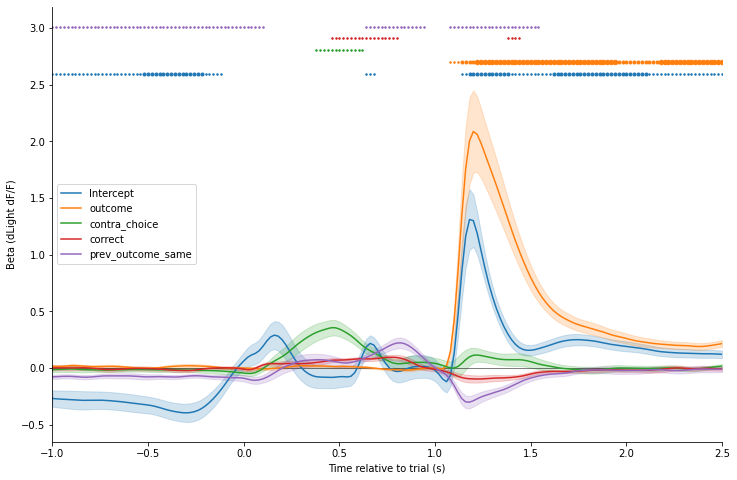

In [24]:
an.regression_analysis(sessions_df, formula="outcome + contra_choice + correct + prev_outcome_same", alignment="trial")